In [1]:
# %load_ext autoreload
# %autoreload 2

import sys
sys.path.append('..')

%env WORKDIR=/Users/jitang/Dev/workdir

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from eofs.xarray import Eof
import cartopy.crs as ccrs

from lib.reanalysis import r1
from lib import obs
from lib.plotting import maps
from lib.enso import oni_trimonthly

env: WORKDIR=/Users/jitang/Dev/workdir


In [634]:
sfo = obs.daily_summary('SFO', '1980-07-01', '2021-06-01')
sfo.loc[sfo.day == '2008-01-03', 'precip_in'] = 0.17
sfo.loc[sfo.day == '2008-01-04', 'precip_in'] = 2.10
sfo.loc[sfo.day == '2008-01-05', 'precip_in'] = 0.77
sfo.loc[sfo.precip_in < 0.1, 'precip_in'] = 0

data_cols = ['day', 'precip_in', 'max_temp_f', 'min_temp_f', 'climo_high_f', 'climo_low_f']

sfo_modified = sfo[data_cols]
sfo_modified['max_temp_anom'] = sfo_modified.max_temp_f - sfo_modified.climo_high_f
sfo_modified['min_temp_anom'] = sfo_modified.min_temp_f - sfo_modified.climo_low_f

sfo_monthly = sfo_modified[['day', 'precip_in', 'max_temp_anom', 'min_temp_anom']].resample('MS', on='day').agg({
    'precip_in': np.sum,
    'max_temp_anom': np.mean,
    'min_temp_anom': np.mean
}).reset_index()

djf = sfo_monthly[sfo_monthly.day.dt.month.isin([12, 1, 2, 3])]

<ipython-input-634-0210faffa1db>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sfo_modified['max_temp_anom'] = sfo_modified.max_temp_f - sfo_modified.climo_high_f
<ipython-input-634-0210faffa1db>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sfo_modified['min_temp_anom'] = sfo_modified.min_temp_f - sfo_modified.climo_low_f


In [635]:
djf.precip_in.describe()

count    164.000000
mean       3.397195
std        2.757524
min        0.000000
25%        1.205000
50%        2.780000
75%        5.175000
max       13.520000
Name: precip_in, dtype: float64

In [639]:
# wet_top50 = djf[djf.precip_in > djf.precip_in.mean() + 0.5*djf.precip_in.std()]
# wet_top50.shape

wet_top50 = djf.sort_values(by='precip_in', ascending=False).head(50)
wet_top50.shape

(50, 4)

In [640]:
oni = oni_trimonthly()
wet_top50['month'] = wet_top50.day.dt.month
wet_top50['year'] = wet_top50.day.dt.year

oni_relevant = oni[['ANOM', 'MONTH', 'YR']]
oni_relevant.columns = ['ONI', 'month', 'year']
wet_top50 = wet_top50.merge(oni_relevant)

In [641]:
bbox = (0, 360, 90, 10)
_, _, wet_anoms = r1.hgt_monthly(500, yearmonths=wet_top50.day, bbox=bbox)

In [642]:
solver = Eof(wet_anoms.hgt)

# retrieve the first two EOFs from the solver class
eofs = solver.eofs(neofs=3)

In [643]:
solver.varianceFraction(neigs=3)

<xarray.DataArray 'variance_fractions' (mode: 3)>
array([0.27672106, 0.13757406, 0.11416934], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2
Attributes:
    long_name:  variance_fractions

In [644]:
def plot_nhem_anoms(da, cmap, levels, title, draw=True, colorbar_label='Geopotential height anomaly (dm)'):
    proj = ccrs.NorthPolarStereo(central_longitude=-94.5, true_scale_latitude=None, globe=None)
    m = maps.CartopyMap(proj=proj)
    if draw:
        m.draw()
    m.plot.fill(da, cmap, levels, colorbar=True, colorbar_label=colorbar_label)
    m.textbox.bottom_right(title, fontsize=20)
    m.textbox.top_left('by Jim Tang (@wxmann)', fontsize=16)
    return m

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


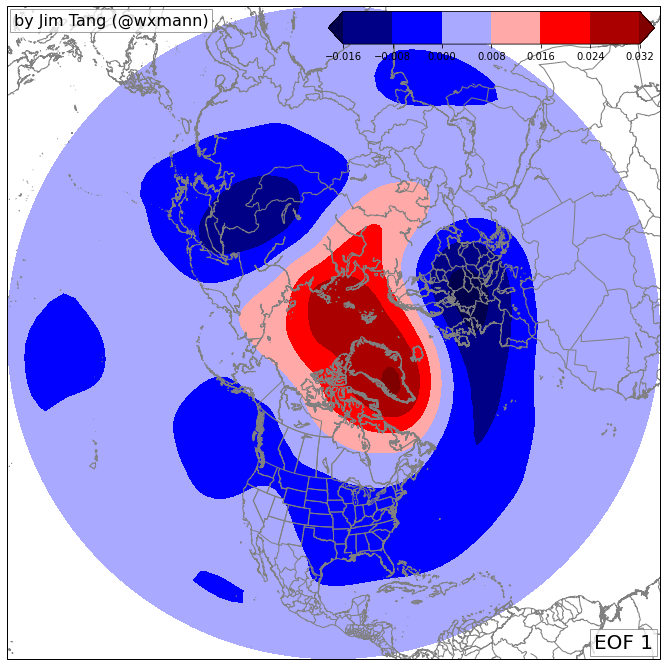

In [645]:
fig = plt.figure(figsize=(12, 12))

da = eofs[0]
cmap = 'seismic'
title = 'EOF 1'

m = plot_nhem_anoms(da, cmap, levels=None, title=title, draw=True, colorbar_label=None)

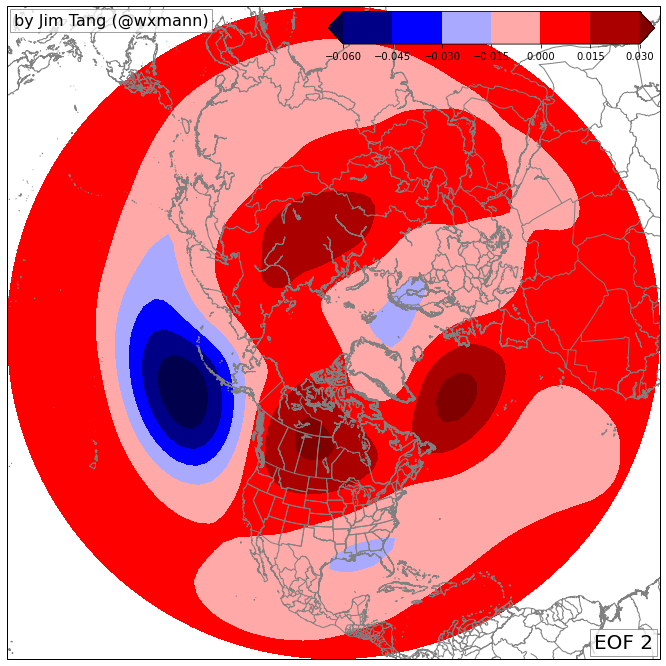

In [646]:
fig = plt.figure(figsize=(12, 12))

da = eofs[1]
cmap = 'seismic'
title = 'EOF 2'

m = plot_nhem_anoms(da, cmap, levels=None, title=title, draw=True, colorbar_label=None)

In [647]:
pcs = solver.pcs(pcscaling=1, npcs=2).to_dataframe().reset_index()
first_pc = pcs[pcs['mode'] == 0]
second_pc = pcs[pcs['mode'] == 1]
wet_with_pcs = wet_top50.merge(
    first_pc[['time', 'pcs']], left_on='day', right_on='time').merge(
    second_pc[['time', 'pcs']], on='time')

wet_with_pcs = wet_with_pcs.rename(columns={
    'pcs_x': 'pc1',
    'pcs_y': 'pc2'
})

In [648]:
in_djf = wet_with_pcs.day.dt.month.isin([12, 1, 2])
wet_with_pcs_djf = wet_with_pcs[in_djf]

in_djfm = wet_with_pcs.day.dt.month.isin([12, 1, 2, 3])
wet_with_pcs_djfm = wet_with_pcs[in_djfm]

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


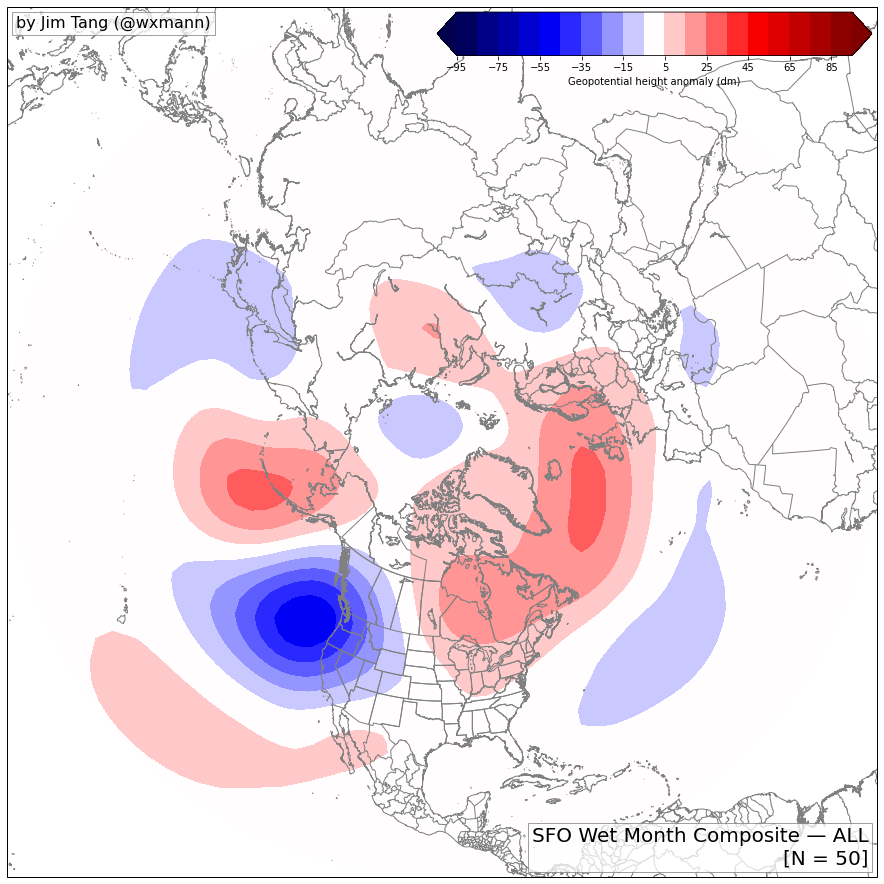

In [649]:
fig = plt.figure(figsize=(16, 16))

_, _, wet_with_pcs_djfm_anoms = r1.hgt_monthly(500, yearmonths=wet_with_pcs_djfm.day, bbox=bbox)
da = wet_with_pcs_djfm_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = np.arange(-95, 96, 10)
title = f'SFO Wet Month Composite — ALL\n[N = {len(wet_with_pcs_djfm.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

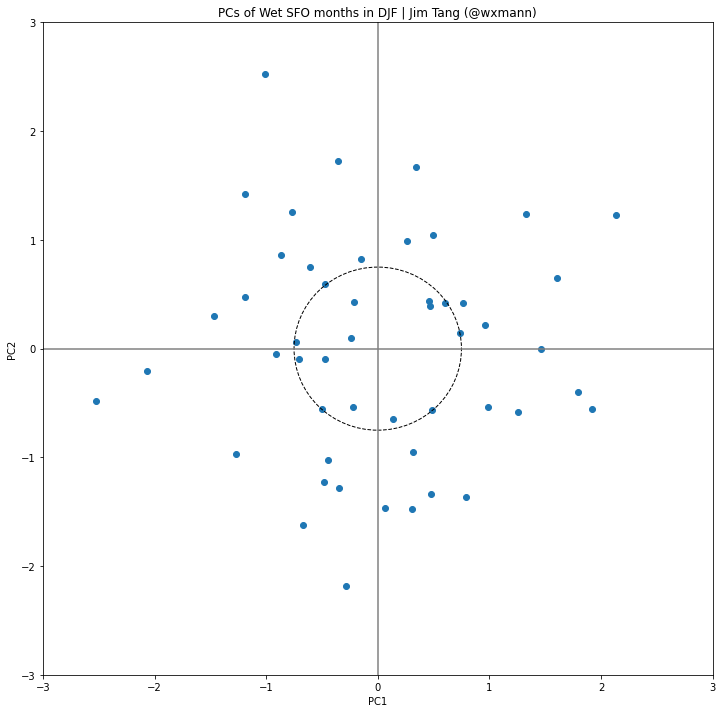

In [650]:
plt.figure(figsize=(12, 12))
plt.scatter(wet_with_pcs_djfm.pc1, wet_with_pcs_djfm.pc2)
plt.axhline(y=0, color='gray')
plt.axvline(x=0, color='gray')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCs of Wet SFO months in DJF | Jim Tang (@wxmann)')
circ = plt.Circle((0, 0), 0.75, color='k', fill=False, ls='--')
plt.gca().add_patch(circ)

## Analysis for just PC2 (Aleutian Region)

In [651]:
# analysis with just pc2 (Aleutian region)
threshold = 0.25

pc2_pos = wet_with_pcs_djfm[(wet_with_pcs_djfm.pc2 > threshold)]
pc2_neg = wet_with_pcs_djfm[(wet_with_pcs_djfm.pc2 < -threshold)]
_, _, pc2_pos_anoms = r1.hgt_monthly(500, yearmonths=pc2_pos.day, bbox=bbox)
_, _, pc2_neg_anoms = r1.hgt_monthly(500, yearmonths=pc2_neg.day, bbox=bbox)

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


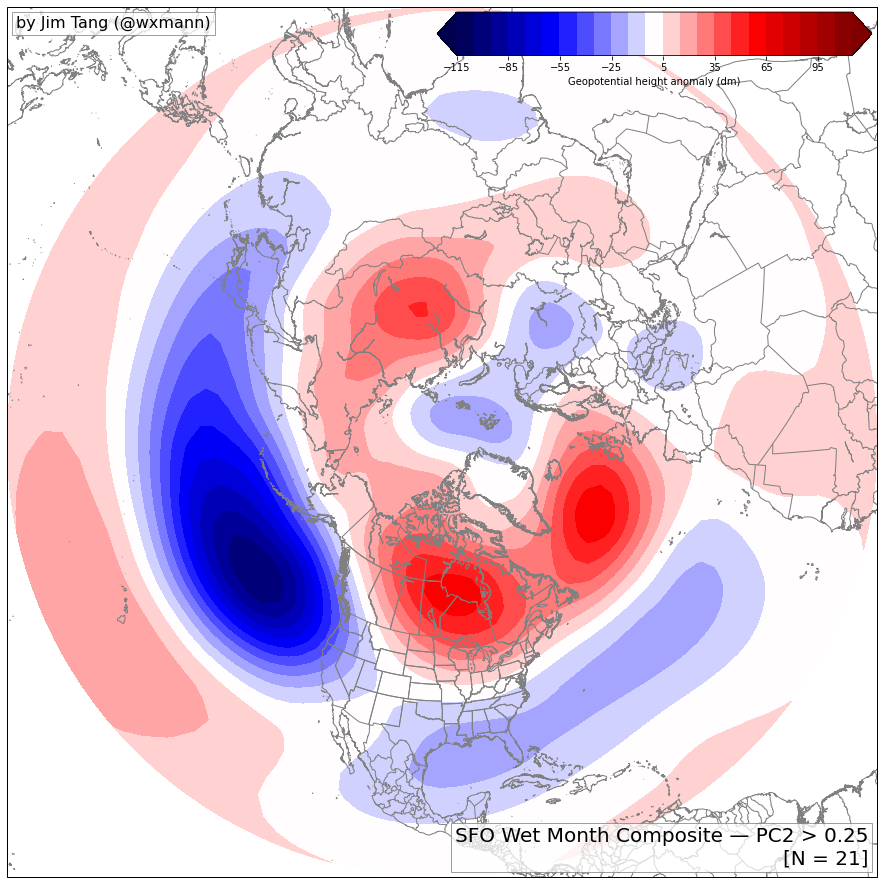

In [652]:
fig = plt.figure(figsize=(16, 16))

da = pc2_pos_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = np.arange(-115, 116, 10)
title = f'SFO Wet Month Composite — PC2 > {threshold}\n[N = {len(pc2_pos_anoms.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


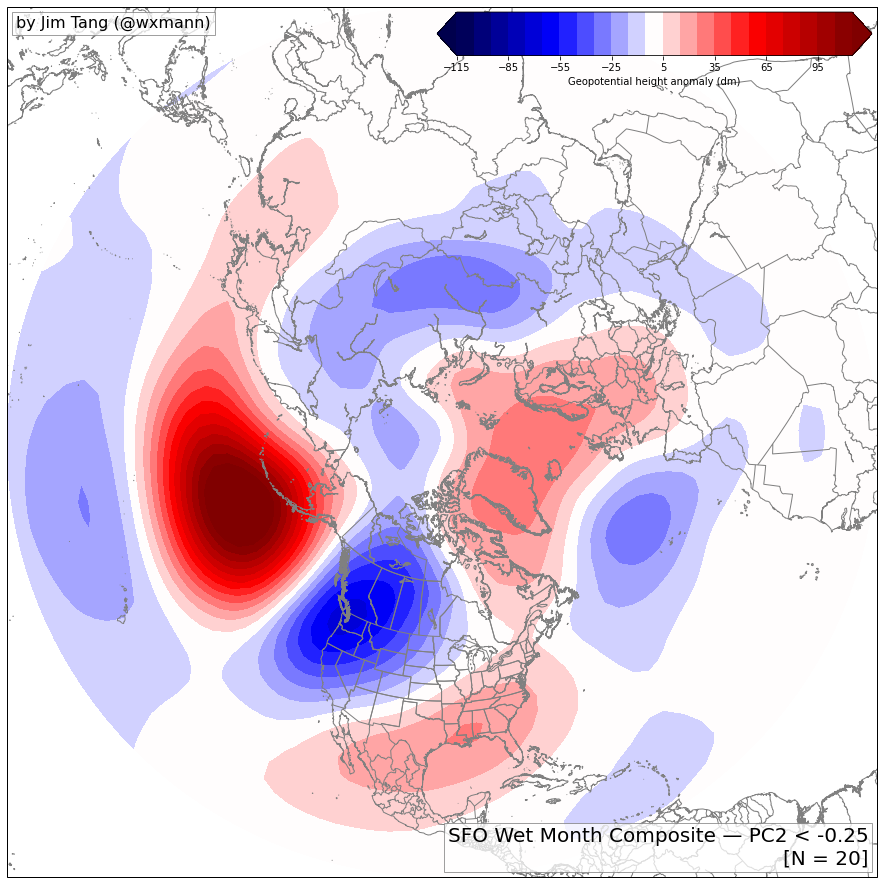

In [653]:
fig = plt.figure(figsize=(16, 16))

da = pc2_neg_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = np.arange(-115, 116, 10)
title = f'SFO Wet Month Composite — PC2 < {-threshold}\n[N = {len(pc2_neg_anoms.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

In [654]:
pc2_pos

day  precip_in  max_temp_anom  min_temp_anom  month  year   ONI  \
0  1998-02-01      13.52      -2.785714       1.446429      2  1998  1.93   
2  2014-12-01      10.47       4.983871       7.341935     12  2014  0.66   
7  1995-01-01       8.76      -0.241935       4.216129      1  1995  0.96   
8  1995-03-01       8.63      -2.070968      -0.025806      3  1995  0.53   
9  2001-12-01       8.27      -0.564516       2.664516     12  2001 -0.31   
10 1983-03-01       8.26      -3.103226       1.490323      3  1983  1.54   
11 2005-12-01       8.17       2.435484       3.277419     12  2005 -0.84   
12 2000-02-01       8.15      -1.724138       2.458621      2  2000 -1.41   
13 1986-02-01       7.87       2.642857       4.339286      2  1986 -0.47   
14 1998-01-01       7.77       0.983871       4.312903      1  1998  2.24   
16 1997-01-01       7.35      -1.177419       2.119355      1  1997 -0.50   
20 1983-01-01       6.75      -2.758065      -1.332258      1  1983  2.18   
21 1983-02-01       6.55      -1.178571       1.982143      2  1983  1.92   
23 1995-12-01       6.27       1.983871       4.212903     12  1995 -0.98   
28 2003-12-01       6.09       0.306452       2.277419     12  2003  0.35   
32 2010-01-01       5.94      -0.661290       2.635484      1  2010  1.50   
37 1981-01-01       5.72       0.306452       1.248387      1  1981 -0.26   
40 2016-01-01       5.31       0.693548       4.183871      1  2016  2.48   
41 2011-03-01       5.13      -2.232258      -0.154839      3  2011 -0.93   
43 2016-03-01       5.05       1.767742       3.877419      3  2016  1.58   
48 1993-02-01       4.54      -1.392857       0.767857      2  1993  0.30   

         time       pc1       pc2  
0  1998-02-01 -1.189053  1.421494  
2  2014-12-01  0.265425  0.991563  
7  1995-01-01  0.492081  1.046950  
8  1995-03-01 -0.208940  0.429001  
9  2001-12-01  0.766529  0.421736  
10 1983-03-01  0.345407  1.666742  
11 2005-12-01  1.326620  1.239700  
12 2000-02-01 -0.147821  0.828699  
13 1986-02-01  0.463357  0.442499  
14 1998-01-01  1.604966  0.650645  
16 1997-01-01 -1.466893  0.298942  
20 1983-01-01 -0.769539  1.252666  
21 1983-02-01 -0.353400  1.726570  
23 1995-12-01 -0.472982  0.592366  
28 2003-12-01 -0.607629  0.753497  
32 2010-01-01  0.602536  0.419902  
37 1981-01-01 -1.013416  2.524518  
40 2016-01-01  2.133837  1.232764  
41 2011-03-01 -1.190427  0.472955  
43 2016-03-01  0.469120  0.388266  
48 1993-02-01 -0.864741  0.865122

In [655]:
pc2_neg

day  precip_in  max_temp_anom  min_temp_anom  month  year   ONI  \
1  1993-01-01      11.07      -1.080645      -1.235484      1  1993  0.09   
3  2008-01-01       9.87      -3.269677      -0.520645      1  2008 -1.64   
6  1982-01-01       8.80      -5.145161      -5.235484      1  1982 -0.05   
15 1982-03-01       7.49      -5.167742      -2.251613      3  1982  0.19   
17 2017-02-01       7.24       0.285714       2.875000      2  2017 -0.16   
18 2019-02-01       7.20      -3.607143      -2.232143      2  2019  0.72   
19 1996-01-01       6.84       0.758065       2.377419      1  1996 -0.90   
22 1996-12-01       6.49       2.274194       4.696774     12  1996 -0.49   
25 2009-02-01       6.24      -1.392857      -0.267857      2  2009 -0.79   
26 2012-12-01       6.23       0.693548       1.793548     12  2012 -0.21   
30 2001-02-01       5.98      -3.071429      -1.267857      2  2001 -0.52   
31 1991-03-01       5.96      -4.361290      -1.122581      3  1991  0.22   
33 1992-12-01       5.92      -1.403226      -0.529032     12  1992 -0.13   
35 2010-12-01       5.80       0.112903       2.890323     12  2010 -1.59   
38 2000-01-01       5.65       1.145161       3.474194      1  2000 -1.66   
39 2006-03-01       5.63      -5.167742      -3.896774      3  2006 -0.57   
42 1994-02-01       5.12      -2.964286      -1.839286      2  1994  0.07   
46 2011-02-01       4.79      -1.321429      -3.303571      2  2011 -1.19   
47 2012-03-01       4.67      -2.135484      -1.187097      3  2012 -0.59   
49 2016-12-01       4.51       0.080645      -2.432258     12  2016 -0.56   

         time       pc1       pc2  
1  1993-01-01 -2.523243 -0.478663  
3  2008-01-01 -0.446672 -1.020879  
6  1982-01-01  0.315093 -0.953038  
15 1982-03-01 -0.346280 -1.281874  
17 2017-02-01 -0.223094 -0.534472  
18 2019-02-01 -0.671778 -1.618002  
19 1996-01-01  0.303072 -1.473808  
22 1996-12-01  0.987186 -0.535324  
25 2009-02-01  0.793884 -1.363623  
26 2012-12-01  1.259343 -0.584938  
30 2001-02-01  0.487635 -0.564624  
31 1991-03-01  0.474599 -1.333279  
33 1992-12-01 -1.268614 -0.969721  
35 2010-12-01  1.796222 -0.401198  
38 2000-01-01 -0.498258 -0.556909  
39 2006-03-01  1.921734 -0.551251  
42 1994-02-01  0.064838 -1.462110  
46 2011-02-01 -0.284883 -2.181632  
47 2012-03-01  0.132671 -0.650122  
49 2016-12-01 -0.485356 -1.226484

In [672]:
wet_with_pcs_djfm[wet_with_pcs_djfm.pc2.abs() < 0.25]

day  precip_in  max_temp_anom  min_temp_anom  month  year   ONI  \
4  2002-12-01       9.37       1.177419       3.019355     12  2002  1.14   
5  2017-01-01       9.19       0.145161      -0.493548      1  2017 -0.34   
24 2004-12-01       6.26       1.403226       1.696774     12  2004  0.69   
27 1992-02-01       6.22       3.103448       2.941379      2  1992  1.63   
29 1983-12-01       6.03       0.661290       4.954839     12  1983 -0.91   
34 1986-03-01       5.83       1.670968       2.522581      3  1986 -0.31   
36 1996-02-01       5.75       0.758621       2.837931      2  1996 -0.75   
44 2005-02-01       4.82       0.857143       3.267857      2  2005  0.58   
45 2018-01-01       4.82       2.822581       3.893548      1  2018 -0.92   

         time       pc1       pc2  
4  2002-12-01  0.736944  0.146873  
5  2017-01-01 -0.707476 -0.096929  
24 2004-12-01 -0.909202 -0.046062  
27 1992-02-01 -0.729381  0.065403  
29 1983-12-01 -0.238103  0.101422  
34 1986-03-01 -2.067758 -0.205285  
36 1996-02-01 -0.476905 -0.096020  
44 2005-02-01  0.958774  0.212885  
45 2018-01-01  1.459969 -0.006932

Text(2.2, 2.5, 'El Nino')

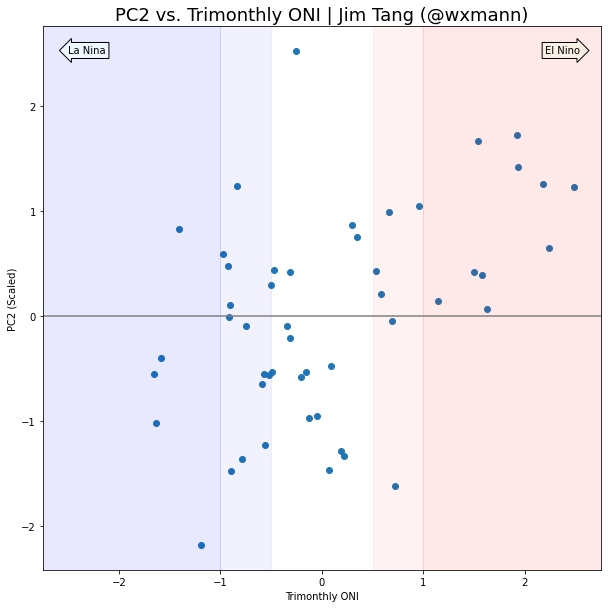

In [676]:
plt.figure(figsize=(10, 10))

plt.scatter(wet_with_pcs_djfm.ONI, wet_with_pcs_djfm.pc2)
plt.title('PC2 vs. Trimonthly ONI | Jim Tang (@wxmann)', fontdict=dict(fontsize=18))
plt.xlabel('Trimonthly ONI')
plt.ylabel('PC2 (Scaled)')
plt.axhline(y=0, color='gray')

# plt.axvline(x=1, color='gray', ls='--')
plt.axvspan(1, 3, color='red', alpha=0.09)

# plt.axvline(x=-1, color='gray', ls='--')
plt.axvspan(-1, -3, color='blue', alpha=0.09)

# plt.axvline(x=0.5, color='gray', ls='--')
plt.axvspan(0.5, 1, color='red', alpha=0.05)

# plt.axvline(x=-0.5, color='gray', ls='--')
plt.axvspan(-0.5, -1, color='blue', alpha=0.05)

plt.xlim([-2.75, 2.75])

plt.text(-2.5, 2.5, 'La Nina', bbox=dict(boxstyle='larrow,pad=0.3', fc='aliceblue'))
plt.text(2.2, 2.5, 'El Nino', bbox=dict(boxstyle='rarrow,pad=0.3', fc='linen'))

(-2.75, 2.75)

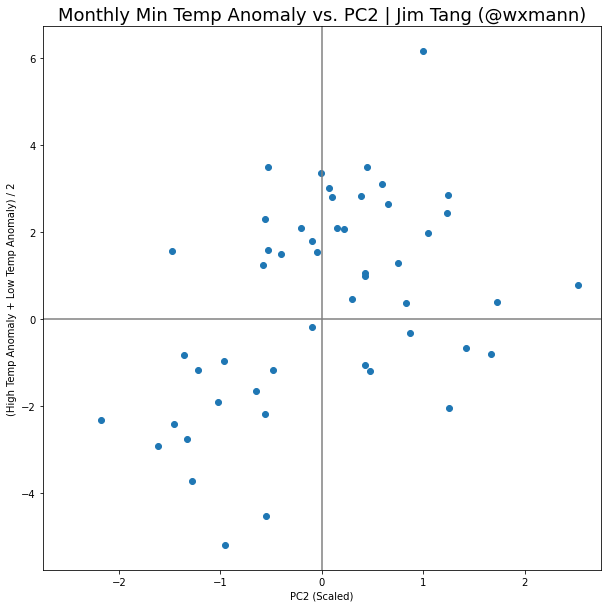

In [684]:
temp_anoms = (wet_with_pcs_djfm.max_temp_anom + wet_with_pcs_djfm.min_temp_anom) / 2

plt.figure(figsize=(10, 10))
plt.scatter(wet_with_pcs_djfm.pc2, temp_anoms)
plt.title('Monthly Min Temp Anomaly vs. PC2 | Jim Tang (@wxmann)', fontdict=dict(fontsize=18))
plt.ylabel('(High Temp Anomaly + Low Temp Anomaly) / 2')
plt.xlabel('PC2 (Scaled)')

plt.axhline(y=0, color='gray')
plt.axvline(x=0, color='gray')

plt.xlim([-2.75, 2.75])

In [686]:
warm_neg_pc2 = wet_with_pcs_djfm[(wet_with_pcs_djfm.pc2 < 0) & (temp_anoms > 0)]
warm_neg_pc2

day  precip_in  max_temp_anom  min_temp_anom  month  year   ONI  \
17 2017-02-01       7.24       0.285714       2.875000      2  2017 -0.16   
19 1996-01-01       6.84       0.758065       2.377419      1  1996 -0.90   
22 1996-12-01       6.49       2.274194       4.696774     12  1996 -0.49   
24 2004-12-01       6.26       1.403226       1.696774     12  2004  0.69   
26 2012-12-01       6.23       0.693548       1.793548     12  2012 -0.21   
34 1986-03-01       5.83       1.670968       2.522581      3  1986 -0.31   
35 2010-12-01       5.80       0.112903       2.890323     12  2010 -1.59   
36 1996-02-01       5.75       0.758621       2.837931      2  1996 -0.75   
38 2000-01-01       5.65       1.145161       3.474194      1  2000 -1.66   
45 2018-01-01       4.82       2.822581       3.893548      1  2018 -0.92   

         time       pc1       pc2  
17 2017-02-01 -0.223094 -0.534472  
19 1996-01-01  0.303072 -1.473808  
22 1996-12-01  0.987186 -0.535324  
24 2004-12-01 -0.909202 -0.046062  
26 2012-12-01  1.259343 -0.584938  
34 1986-03-01 -2.067758 -0.205285  
35 2010-12-01  1.796222 -0.401198  
36 1996-02-01 -0.476905 -0.096020  
38 2000-01-01 -0.498258 -0.556909  
45 2018-01-01  1.459969 -0.006932

In [692]:
cold_neg_pc2 = wet_with_pcs_djfm[(wet_with_pcs_djfm.pc2 < 0) & (temp_anoms < 0)]
cold_neg_pc2

day  precip_in  max_temp_anom  min_temp_anom  month  year   ONI  \
1  1993-01-01      11.07      -1.080645      -1.235484      1  1993  0.09   
3  2008-01-01       9.87      -3.269677      -0.520645      1  2008 -1.64   
5  2017-01-01       9.19       0.145161      -0.493548      1  2017 -0.34   
6  1982-01-01       8.80      -5.145161      -5.235484      1  1982 -0.05   
15 1982-03-01       7.49      -5.167742      -2.251613      3  1982  0.19   
18 2019-02-01       7.20      -3.607143      -2.232143      2  2019  0.72   
25 2009-02-01       6.24      -1.392857      -0.267857      2  2009 -0.79   
30 2001-02-01       5.98      -3.071429      -1.267857      2  2001 -0.52   
31 1991-03-01       5.96      -4.361290      -1.122581      3  1991  0.22   
33 1992-12-01       5.92      -1.403226      -0.529032     12  1992 -0.13   
39 2006-03-01       5.63      -5.167742      -3.896774      3  2006 -0.57   
42 1994-02-01       5.12      -2.964286      -1.839286      2  1994  0.07   
46 2011-02-01       4.79      -1.321429      -3.303571      2  2011 -1.19   
47 2012-03-01       4.67      -2.135484      -1.187097      3  2012 -0.59   
49 2016-12-01       4.51       0.080645      -2.432258     12  2016 -0.56   

         time       pc1       pc2  
1  1993-01-01 -2.523243 -0.478663  
3  2008-01-01 -0.446672 -1.020879  
5  2017-01-01 -0.707476 -0.096929  
6  1982-01-01  0.315093 -0.953038  
15 1982-03-01 -0.346280 -1.281874  
18 2019-02-01 -0.671778 -1.618002  
25 2009-02-01  0.793884 -1.363623  
30 2001-02-01  0.487635 -0.564624  
31 1991-03-01  0.474599 -1.333279  
33 1992-12-01 -1.268614 -0.969721  
39 2006-03-01  1.921734 -0.551251  
42 1994-02-01  0.064838 -1.462110  
46 2011-02-01 -0.284883 -2.181632  
47 2012-03-01  0.132671 -0.650122  
49 2016-12-01 -0.485356 -1.226484

In [688]:
cold_pos_pc2 = wet_with_pcs_djfm[(wet_with_pcs_djfm.pc2 > 0) & (temp_anoms < 0)]
cold_pos_pc2

day  precip_in  max_temp_anom  min_temp_anom  month  year   ONI  \
0  1998-02-01      13.52      -2.785714       1.446429      2  1998  1.93   
8  1995-03-01       8.63      -2.070968      -0.025806      3  1995  0.53   
10 1983-03-01       8.26      -3.103226       1.490323      3  1983  1.54   
20 1983-01-01       6.75      -2.758065      -1.332258      1  1983  2.18   
41 2011-03-01       5.13      -2.232258      -0.154839      3  2011 -0.93   
48 1993-02-01       4.54      -1.392857       0.767857      2  1993  0.30   

         time       pc1       pc2  
0  1998-02-01 -1.189053  1.421494  
8  1995-03-01 -0.208940  0.429001  
10 1983-03-01  0.345407  1.666742  
20 1983-01-01 -0.769539  1.252666  
41 2011-03-01 -1.190427  0.472955  
48 1993-02-01 -0.864741  0.865122

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


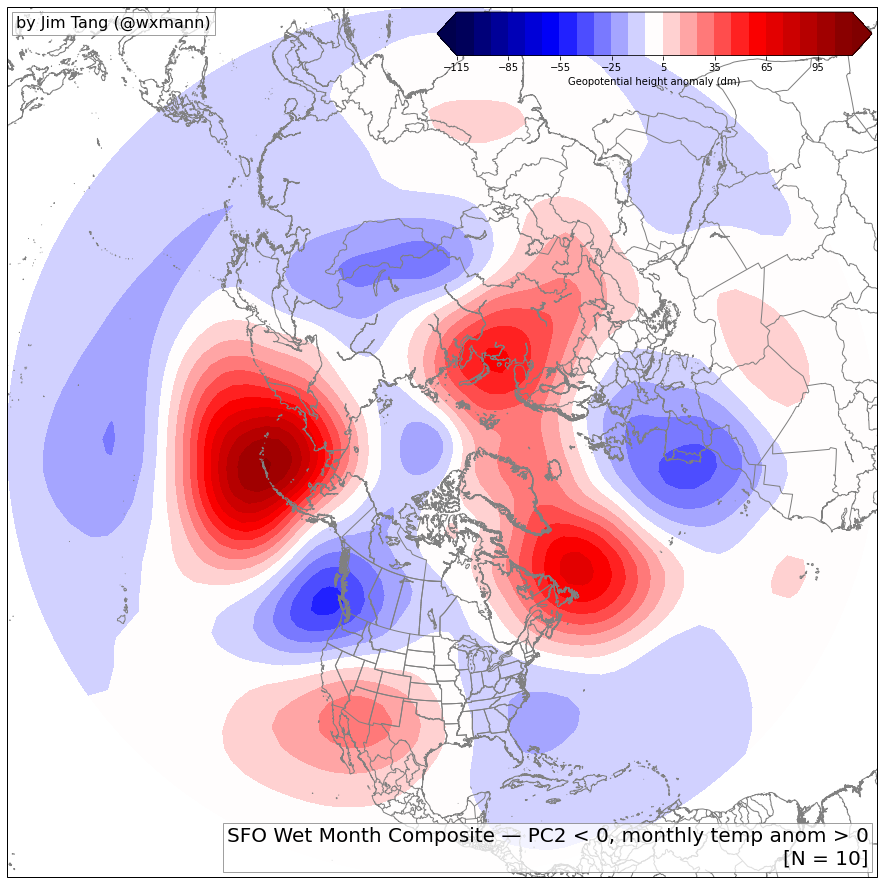

In [689]:
fig = plt.figure(figsize=(16, 16))

_, _, warm_neg_pc2_anoms = r1.hgt_monthly(500, yearmonths=warm_neg_pc2.day, bbox=bbox)
da = warm_neg_pc2_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = np.arange(-115, 116, 10)
title = f'SFO Wet Month Composite — PC2 < 0, monthly temp anom > 0\n[N = {len(warm_neg_pc2_anoms.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


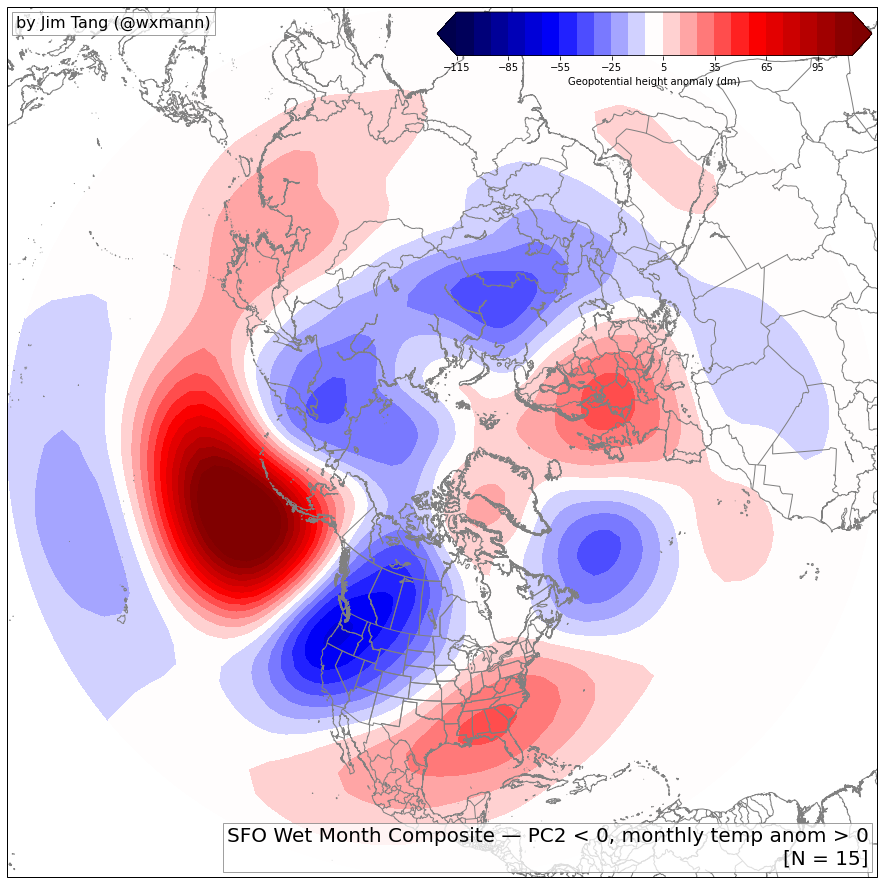

In [693]:
fig = plt.figure(figsize=(16, 16))

_, _, cold_neg_pc2_anoms = r1.hgt_monthly(500, yearmonths=cold_neg_pc2.day, bbox=bbox)
da = cold_neg_pc2_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = np.arange(-115, 116, 10)
title = f'SFO Wet Month Composite — PC2 < 0, monthly temp anom < 0\n[N = {len(cold_neg_pc2_anoms.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

## Analysis Per Quadrant

In [660]:
min_amplitude = 0.75
cod = wet_with_pcs.pc1 ** 2 + wet_with_pcs.pc2 ** 2 < min_amplitude ** 2
threshold = 0

# analysis with four quandrants
q1 = wet_with_pcs[(wet_with_pcs.pc1 > threshold) & (wet_with_pcs.pc2 > threshold) & ~cod]
_, _, q1_anoms = r1.hgt_monthly(500, yearmonths=q1.day, bbox=bbox)

q2 = wet_with_pcs[(wet_with_pcs.pc1 < -threshold) & (wet_with_pcs.pc2 > threshold) & ~cod]
_, _, q2_anoms = r1.hgt_monthly(500, yearmonths=q2.day, bbox=bbox)

q3 = wet_with_pcs[(wet_with_pcs.pc1 < -threshold) & (wet_with_pcs.pc2 < -threshold) & ~cod]
_, _, q3_anoms = r1.hgt_monthly(500, yearmonths=q3.day, bbox=bbox)

q4 = wet_with_pcs[(wet_with_pcs.pc1 > threshold) & (wet_with_pcs.pc2 < -threshold) & ~cod]
_, _, q4_anoms = r1.hgt_monthly(500, yearmonths=q4.day, bbox=bbox)

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


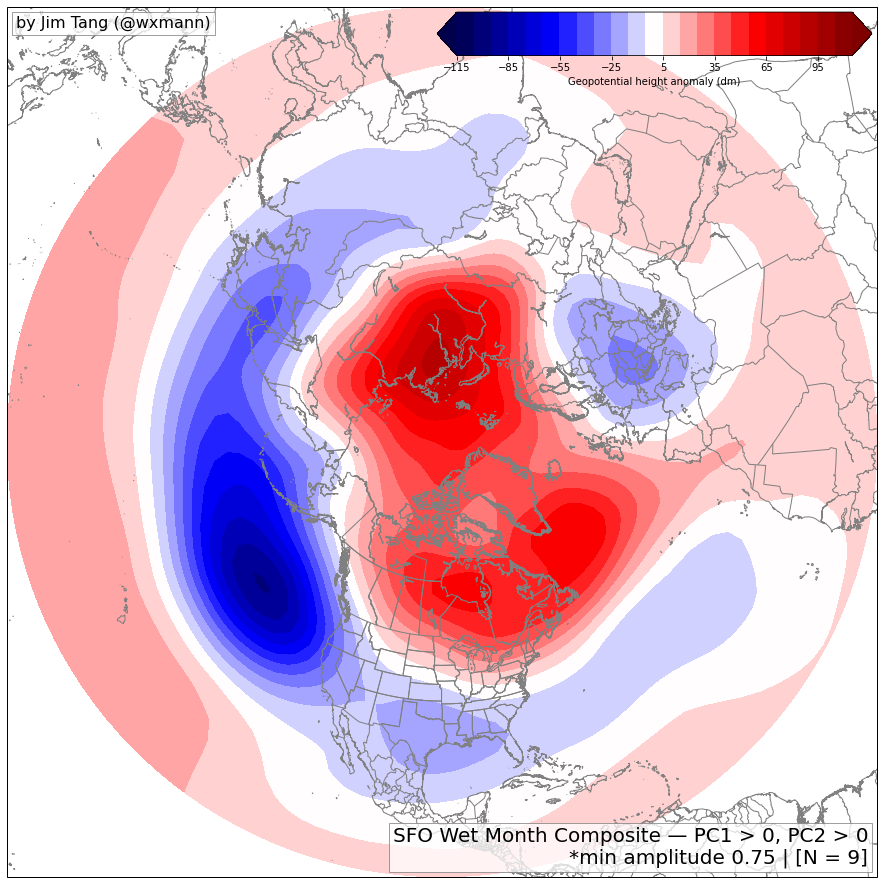

In [661]:
fig = plt.figure(figsize=(16, 16))

da = q1_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = np.arange(-115, 116, 10)
title = f'SFO Wet Month Composite — PC1 > 0, PC2 > 0\n*min amplitude {min_amplitude} | [N = {len(q1_anoms.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

In [662]:
fig = plt.figure(figsize=(16, 16))

da = q2_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = np.arange(-115, 116, 10)
title = f'SFO Wet Month Composite — PC1 < 0, PC2 > 0\n*min amplitude {min_amplitude} | [N = {len(q2_anoms.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


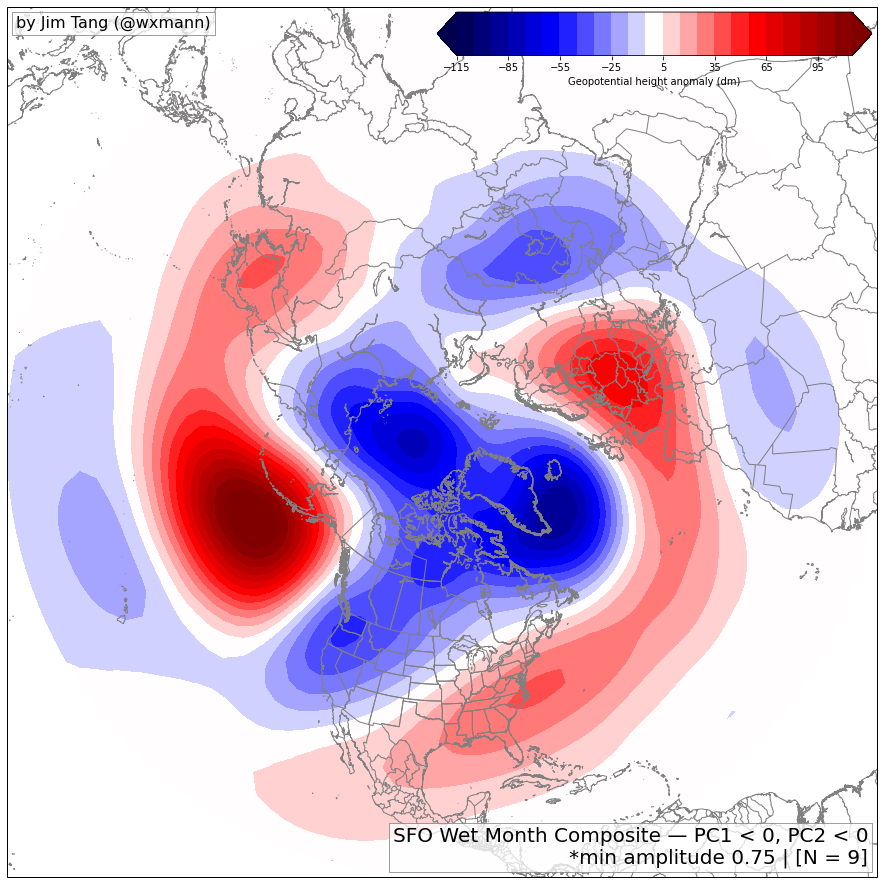

In [663]:
fig = plt.figure(figsize=(16, 16))

da = q3_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = np.arange(-115, 116, 10)
title = f'SFO Wet Month Composite — PC1 < 0, PC2 < 0\n*min amplitude {min_amplitude} | [N = {len(q3_anoms.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


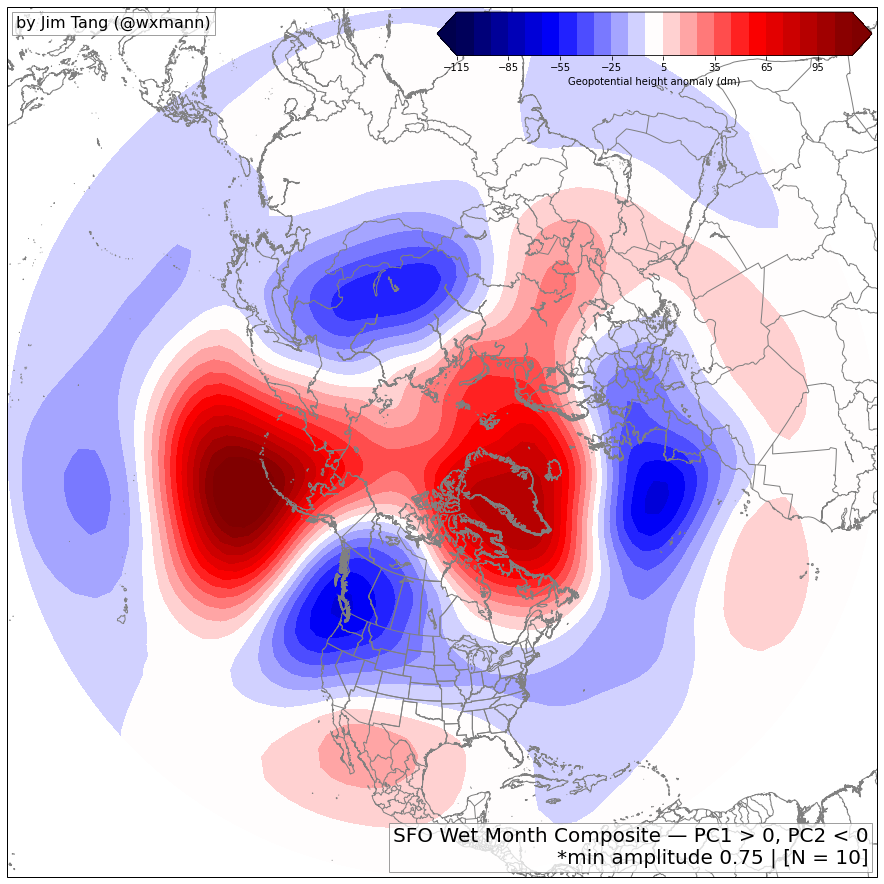

In [664]:
fig = plt.figure(figsize=(16, 16))

da = q4_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = np.arange(-115, 116, 10)
title = f'SFO Wet Month Composite — PC1 > 0, PC2 < 0\n*min amplitude {min_amplitude} | [N = {len(q4_anoms.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

In [666]:
q1

day  precip_in  max_temp_anom  min_temp_anom  month  year   ONI  \
2  2014-12-01      10.47       4.983871       7.341935     12  2014  0.66   
4  2002-12-01       9.37       1.177419       3.019355     12  2002  1.14   
7  1995-01-01       8.76      -0.241935       4.216129      1  1995  0.96   
9  2001-12-01       8.27      -0.564516       2.664516     12  2001 -0.31   
10 1983-03-01       8.26      -3.103226       1.490323      3  1983  1.54   
11 2005-12-01       8.17       2.435484       3.277419     12  2005 -0.84   
14 1998-01-01       7.77       0.983871       4.312903      1  1998  2.24   
40 2016-01-01       5.31       0.693548       4.183871      1  2016  2.48   
44 2005-02-01       4.82       0.857143       3.267857      2  2005  0.58   

         time       pc1       pc2  
2  2014-12-01  0.265425  0.991563  
4  2002-12-01  0.736944  0.146873  
7  1995-01-01  0.492081  1.046950  
9  2001-12-01  0.766529  0.421736  
10 1983-03-01  0.345407  1.666742  
11 2005-12-01  1.326620  1.239700  
14 1998-01-01  1.604966  0.650645  
40 2016-01-01  2.133837  1.232764  
44 2005-02-01  0.958774  0.212885

In [667]:
q2

day  precip_in  max_temp_anom  min_temp_anom  month  year   ONI  \
0  1998-02-01      13.52      -2.785714       1.446429      2  1998  1.93   
12 2000-02-01       8.15      -1.724138       2.458621      2  2000 -1.41   
16 1997-01-01       7.35      -1.177419       2.119355      1  1997 -0.50   
20 1983-01-01       6.75      -2.758065      -1.332258      1  1983  2.18   
21 1983-02-01       6.55      -1.178571       1.982143      2  1983  1.92   
23 1995-12-01       6.27       1.983871       4.212903     12  1995 -0.98   
28 2003-12-01       6.09       0.306452       2.277419     12  2003  0.35   
37 1981-01-01       5.72       0.306452       1.248387      1  1981 -0.26   
41 2011-03-01       5.13      -2.232258      -0.154839      3  2011 -0.93   
48 1993-02-01       4.54      -1.392857       0.767857      2  1993  0.30   

         time       pc1       pc2  
0  1998-02-01 -1.189053  1.421494  
12 2000-02-01 -0.147821  0.828699  
16 1997-01-01 -1.466893  0.298942  
20 1983-01-01 -0.769539  1.252666  
21 1983-02-01 -0.353400  1.726570  
23 1995-12-01 -0.472982  0.592366  
28 2003-12-01 -0.607629  0.753497  
37 1981-01-01 -1.013416  2.524518  
41 2011-03-01 -1.190427  0.472955  
48 1993-02-01 -0.864741  0.865122

In [668]:
q3

day  precip_in  max_temp_anom  min_temp_anom  month  year   ONI  \
1  1993-01-01      11.07      -1.080645      -1.235484      1  1993  0.09   
3  2008-01-01       9.87      -3.269677      -0.520645      1  2008 -1.64   
15 1982-03-01       7.49      -5.167742      -2.251613      3  1982  0.19   
18 2019-02-01       7.20      -3.607143      -2.232143      2  2019  0.72   
24 2004-12-01       6.26       1.403226       1.696774     12  2004  0.69   
33 1992-12-01       5.92      -1.403226      -0.529032     12  1992 -0.13   
34 1986-03-01       5.83       1.670968       2.522581      3  1986 -0.31   
46 2011-02-01       4.79      -1.321429      -3.303571      2  2011 -1.19   
49 2016-12-01       4.51       0.080645      -2.432258     12  2016 -0.56   

         time       pc1       pc2  
1  1993-01-01 -2.523243 -0.478663  
3  2008-01-01 -0.446672 -1.020879  
15 1982-03-01 -0.346280 -1.281874  
18 2019-02-01 -0.671778 -1.618002  
24 2004-12-01 -0.909202 -0.046062  
33 1992-12-01 -1.268614 -0.969721  
34 1986-03-01 -2.067758 -0.205285  
46 2011-02-01 -0.284883 -2.181632  
49 2016-12-01 -0.485356 -1.226484

In [669]:
q4

day  precip_in  max_temp_anom  min_temp_anom  month  year   ONI  \
6  1982-01-01       8.80      -5.145161      -5.235484      1  1982 -0.05   
19 1996-01-01       6.84       0.758065       2.377419      1  1996 -0.90   
22 1996-12-01       6.49       2.274194       4.696774     12  1996 -0.49   
25 2009-02-01       6.24      -1.392857      -0.267857      2  2009 -0.79   
26 2012-12-01       6.23       0.693548       1.793548     12  2012 -0.21   
31 1991-03-01       5.96      -4.361290      -1.122581      3  1991  0.22   
35 2010-12-01       5.80       0.112903       2.890323     12  2010 -1.59   
39 2006-03-01       5.63      -5.167742      -3.896774      3  2006 -0.57   
42 1994-02-01       5.12      -2.964286      -1.839286      2  1994  0.07   
45 2018-01-01       4.82       2.822581       3.893548      1  2018 -0.92   

         time       pc1       pc2  
6  1982-01-01  0.315093 -0.953038  
19 1996-01-01  0.303072 -1.473808  
22 1996-12-01  0.987186 -0.535324  
25 2009-02-01  0.793884 -1.363623  
26 2012-12-01  1.259343 -0.584938  
31 1991-03-01  0.474599 -1.333279  
35 2010-12-01  1.796222 -0.401198  
39 2006-03-01  1.921734 -0.551251  
42 1994-02-01  0.064838 -1.462110  
45 2018-01-01  1.459969 -0.006932

In [691]:
plt.figure(figsize=(12, 8))
plt.boxplot([q1.min_temp_anom, q2.min_temp_anom, q3.min_temp_anom, q4.min_temp_anom])

{'whiskers': [<matplotlib.lines.Line2D at 0x17e58fc10>,
 'caps': [<matplotlib.lines.Line2D at 0x147ff0310>,
 'boxes': [<matplotlib.lines.Line2D at 0x17e58f8b0>,
 'medians': [<matplotlib.lines.Line2D at 0x147ff09d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x147ff0d30>,
 'means': []}